<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S4/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!pip install torchsummary

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np


In [60]:
cpu = torch.device("cpu")
torch.manual_seed(1)

def isCuda():
  return torch.cuda.is_available()

def randInt(min, max, size): 
  return torch.LongTensor(size).random_(min, max)

def getDevice(): 
  return torch.device("cuda" if isCuda() else "cpu")

def train_transformations(): 
  return transforms.Compose([
                    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
                    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  
def test_transformations(): 
  return transforms.Compose([
                    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

def MNIST(isTrain=True, transforms=train_transformations()): 
  return datasets.MNIST("../data", isTrain, transform=transforms, download=True)

def dataLoader(dataset): 
  args = {'num_workers': 1, 'pin_memory': True} if isCuda() else {}
  return torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, **args)

def showImages(images, labels, cols=5, figsize=(12, 10)):
  num_images = len(images)
  rows = np.ceil(num_images/float(cols))
  fig, axis = plt.subplots(int(rows), cols, figsize=figsize)
  for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(image)
        ax.set(title = f"{label}") 

train_data = MNIST()
train_loader = dataLoader(train_data)

test_data = MNIST(isTrain=False, transforms=test_transformations())
test_loader = dataLoader(test_data)

print(f'\nSize of train data:{train_data.data.shape}')
print(f'\nSize of test data:{test_data.data.shape}')

# randImages = randInt(0, len(test_data.data), 20)
# showImages(test_data.data[randImages], test_data.targets[randImages])


Size of train data:torch.Size([60000, 28, 28])

Size of test data:torch.Size([10000, 28, 28])


In [61]:
class Net(nn.Module): 

  def __init__(self): 
    super(Net, self).__init__()

    # RF - 7x7
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 8, 3, padding=1), 
        nn.ReLU(), 
        nn.BatchNorm2d(8),
        nn.Dropout2d(0.075),
        nn.Conv2d(8, 16, 3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(0.075),
        nn.Conv2d(16, 32, 3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout2d(0.075)
    )

    # RF - 14x14
    self.transition1 = nn.Sequential(
        nn.Conv2d(32, 8, 1),
        nn.MaxPool2d(2, 2)
    )

    # RF - 16x16
    self.conv2 = nn.Sequential(
        nn.Conv2d(8, 16, 3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(0.075),
        nn.Conv2d(16, 32, 3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout2d(0.075)
    )

    # RF - 32x32
    self.transition2 = nn.Sequential(
        nn.Conv2d(32, 8, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    # RF - 36x36
    self.conv3 = nn.Sequential(
        nn.Conv2d(8, 16, 3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(0.075),
        nn.Conv2d(16, 32, 3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout2d(0.075)
    )

    self.conv4 = nn.Conv2d(32, 10, 1)
    self.gap1 = nn.AdaptiveAvgPool2d(1)

  def forward(self, x): 

    x = self.transition1(self.conv1(x))
    x = self.transition2(self.conv2(x))
    x = self.gap1(self.conv4(self.conv3(x)))
    x = x.view(-1, 10)
    return F.log_softmax(x)

  def summarize(self, input): 
    summary(self, input_size=input)

net = Net().to(getDevice())
net.summarize((1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,168
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]           4,640
             ReLU-10           [-1, 32, 28, 28]               0
      BatchNorm2d-11           [-1, 32, 28, 28]              64
        Dropout2d-12           [-1, 32, 28, 28]               0
           Conv2d-13            [-1, 8, 28, 28]             264
        MaxPool2d-14            [-1, 8,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
def compute_accuracy(prediction, target): 
  return 100 * prediction.eq(target.view_as(prediction)).sum().item() / float(len(prediction))

def compute_metrics(data, prediction, target): 
  corrects = prediction.eq(target.view_as(prediction))
  accuracy = corrects.sum().item() / len(prediction)
  miss_indices = ~corrects
  miss_data = data[miss_indices]  
  miss_predictions = prediction[miss_indices]
  miss_targets = target[miss_indices]
  print(confusion_matrix(target.to(cpu), prediction.to(cpu)))
  return accuracy * 100, (miss_data, miss_predictions, miss_targets)

In [0]:
def train_one_batch(model, data, target, optimizer): 
  optimizer.zero_grad()
  output = model(data)
  loss = F.nll_loss(output, target)
  loss.backward()
  optimizer.step()
  return (loss, output.argmax(dim=1))

def train_one_epoch(model, train_loader, optimizer, device=getDevice()): 
  model.train()
  pbar = tqdm(train_loader, ncols=1000) 
  wholePred = []
  wholeData = []
  wholeTarget = []
  for idx, (data, target) in enumerate(pbar): 
    data, target = data.to(device), target.to(device)
    (loss, prediction) = train_one_batch(model, data, target, optimizer)
    accuracy = compute_accuracy(prediction, target)
    pbar.set_description(desc= f'Loss={loss.item()}\t id={idx}\t accuracy={accuracy}')
    wholePred.append(prediction)
    wholeData.append(data)
    wholeTarget.append(target)
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred))

def train(model, train_loader, optimizer, epoch): 
  for e in range(0, epoch): 
    (train_data, train_target, train_prediction) = train_one_epoch(model, train_loader, optimizer)
    print(f'\nTrain Accuracy for epoch:{e + 1} is {compute_accuracy(train_prediction, train_target)}%')
    

In [0]:
def test_one_batch(model, data, target): 
  output = model(data)
  loss = F.nll_loss(output, target)  
  return (loss, output.argmax(dim=1))
  
def test(model, test_loader, device=getDevice()): 
  model.eval()
  pbar = tqdm(test_loader, ncols=1000)
  wholePred = []
  wholeData = []
  wholeTarget = []
  with torch.no_grad(): 
    for idx, (data, target) in enumerate(pbar): 
      data, target = data.to(device), target.to(device)
      (loss, prediction) = test_one_batch(model, data, target)
      accuracy = compute_accuracy(prediction, target)
      pbar.set_description(desc= f'Loss={loss.item()}\t id={idx}\t accuracy={accuracy}%')
      wholePred.append(prediction)
      wholeData.append(data)
      wholeTarget.append(target)
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred))

In [65]:

optimizer = optim.SGD(net.parameters(), lr = 0.02, momentum=0.9)
train(net, train_loader, optimizer, 20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Train Accuracy for epoch:1 is 79.41833333333334%



Train Accuracy for epoch:2 is 94.72666666666667%



Train Accuracy for epoch:3 is 95.91833333333334%



Train Accuracy for epoch:4 is 96.41333333333333%



Train Accuracy for epoch:5 is 96.805%



Train Accuracy for epoch:6 is 97.06166666666667%



Train Accuracy for epoch:7 is 97.22%



Train Accuracy for epoch:8 is 97.36333333333333%



Train Accuracy for epoch:9 is 97.515%



Train Accuracy for epoch:10 is 97.59333333333333%



Train Accuracy for epoch:11 is 97.70833333333333%



Train Accuracy for epoch:12 is 97.80333333333333%



Train Accuracy for epoch:13 is 97.77%



Train Accuracy for epoch:14 is 97.78333333333333%



Train Accuracy for epoch:15 is 97.95%



Train Accuracy for epoch:16 is 97.955%



Train Accuracy for epoch:17 is 97.96166666666667%



Train Accuracy for epoch:18 is 97.99166666666666%



Train Accuracy for epoch:19 is 98.03%



Train Accuracy for epoch:20 is 98.17333333333333%


In [66]:
(test_data, test_target, test_prediction) = test(net, test_loader)
accuracy, (miss_data, miss_predictions, miss_targets) = compute_metrics(test_data, test_prediction, test_target)
print(f'Test Accuracy = {accuracy}%')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 977    0    0    0    0    0    1    2    0    0]
 [   0 1129    1    1    0    1    1    2    0    0]
 [   1    0 1028    0    0    0    1    2    0    0]
 [   0    0    0 1007    0    3    0    0    0    0]
 [   0    0    0    0  972    0    1    0    1    8]
 [   1    0    0    6    0  881    2    0    2    0]
 [   1    2    0    0    1    1  953    0    0    0]
 [   0    2    2    0    0    0    0 1023    0    1]
 [   0    0    4    1    0    1    0    0  965    3]
 [   0    0    0    0    3    0    0    1    0 1005]]
Test Accuracy = 99.4%


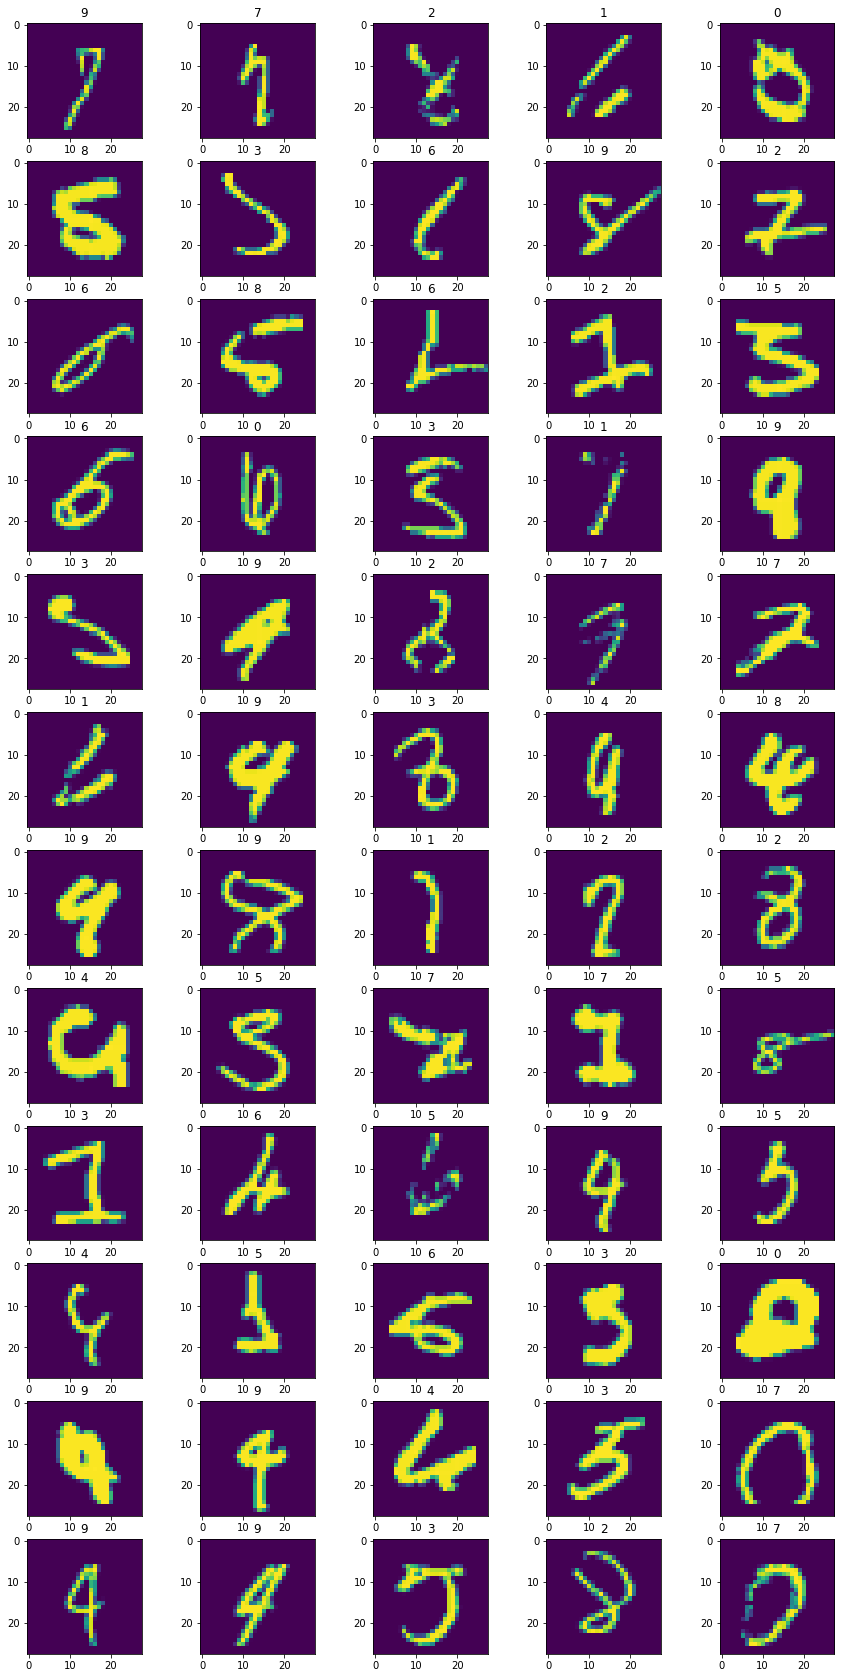

In [67]:
showImages(miss_data.view(-1, 28, 28).to(cpu), miss_predictions.to(cpu), figsize=(15, 30))